# Team no. -> 35

### member 1-> Himanshu Singhal (24120030)
### member 2-> Gaurav Kumar (24120027)  

In [ ]:
!pip install -q augly transformers datasets torch torchvision scikit-learn


# Cats & Dogs Dataset Preparation and Augmentation

This document explains the process of preparing and augmenting a Cats & Dogs dataset. The steps include:

- Installing required packages
- Unzipping the dataset
- Splitting data into training and test sets
- Augmenting the training images with random transformations

Each code block is documented to explain its functionality.

---

## 1. Installation and Data Unzipping

Install the required packages and unzip the dataset.


In [ ]:
import os
import random
import zipfile
import shutil
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import augly.image as imaugs
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm


In [ ]:
!unzip test.zip -d cats_dogs_dataset

In [ ]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# Paths
base_dir = "/content/cats_dogs_dataset"  # Folder with 'cats/' and 'dogs/'
train_dir = "/content/train"
test_dir = "/content/test"

# Create train and test directories
for folder in [train_dir, test_dir]:
    os.makedirs(os.path.join(folder, "cats"), exist_ok=True)
    os.makedirs(os.path.join(folder, "dogs"), exist_ok=True)

# Function to split and move files
def split_and_move(category):
    files = os.listdir(os.path.join(base_dir, category))
    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)

    for file in train_files:
        shutil.copy(os.path.join(base_dir, category, file), os.path.join(train_dir, category, file))

    for file in test_files:
        shutil.copy(os.path.join(base_dir, category, file), os.path.join(test_dir, category, file))

# Apply function to both categories
for category in ["cats", "dogs"]:
    split_and_move(category)

# Check dataset distribution
print(f"Train set: {len(os.listdir(train_dir+'/cats'))} cats, {len(os.listdir(train_dir+'/dogs'))} dogs")
print(f"Test set: {len(os.listdir(test_dir+'/cats'))} cats, {len(os.listdir(test_dir+'/dogs'))} dogs")


Train set: 56 cats, 56 dogs
Test set: 14 cats, 14 dogs


# Augmentation Types and Their Effects

This document describes the image augmentation techniques used in our project. These augmentations increase the diversity of the training data, helping the model generalize better by simulating various real-world conditions.

---

## 1. Rotate
- **Function:** `imaugs.Rotate(degrees=45)`
- **Description:** Rotates the image by a specified number of degrees (45° in this case).
- **Effect:** Simulates different orientations of the subject, making the model invariant to rotational differences.

---

## 2. Crop
- **Function:** `imaugs.Crop()`
- **Description:** Randomly crops a portion of the image.
- **Effect:** Emulates zooming or focusing on different parts of the image, helping the model learn from partial views.

---

## 3. Blur
- **Function:** `imaugs.Blur()`
- **Description:** Applies a blur filter to soften the image.
- **Effect:** Reduces reliance on fine details and makes the model more robust to noisy inputs.

---

## 4. ColorJitter
- **Function:** `imaugs.ColorJitter(brightness_factor=1.5)`
- **Description:** Adjusts the brightness (and optionally other color properties) of the image.
- **Effect:** Simulates variations in lighting conditions, ensuring the model can handle images captured under different illumination.

---

## 5. Horizontal Flip (HFlip)
- **Function:** `imaugs.HFlip()`
- **Description:** Flips the image horizontally.
- **Effect:** Doubles the effective dataset by mirroring images, which is useful when the horizontal orientation does not affect the image content.

---

## 6. Grayscale
- **Function:** `imaugs.Grayscale()`
- **Description:** Converts the image to grayscale.
- **Effect:** Forces the model to rely on texture and shape rather than color, which can improve performance when color information is less significant.

---

## 7. Random Noise
- **Function:** `imaugs.RandomNoise(seed=42)`
- **Description:** Adds random noise to the image.
- **Effect:** Simulates sensor noise and helps the model become robust to slight variations and imperfections in the input data.

---

## 8. Overlay Text
- **Function:** `imaugs.OverlayText(text=[79, 66, 332, 903, 46], font_size=0.2)`
- **Description:** Overlays text onto the image.
- **Effect:** Introduces additional visual elements that can prevent overfitting by forcing the model to focus on essential features.

---

## 9. Overlay Emoji
- **Function:** `imaugs.OverlayEmoji(emoji_path="/content/smile.png")`
- **Description:** Overlays an emoji onto the image.
- **Effect:** Similar to text overlay, it adds extra visual features that enhance diversity and challenge the model to ignore irrelevant details.

---

## 10. Random Aspect Ratio
- **Function:** `imaugs.RandomAspectRatio(min_ratio=0.5, max_ratio=2.0)`
- **Description:** Randomly changes the aspect ratio of the image within the specified range.
- **Effect:** Helps the model learn to handle images with varying shapes and sizes, improving its robustness to different framing scenarios.

---

This documentation provides a clear overview of the augmentation techniques used, explaining both their implementation and their intended impact on model performance.


In [ ]:
def augment_image(image_path, output_path):
    """Apply 3 random augmentations sequentially"""
    augmentations = [
    imaugs.Rotate(degrees=45),
    imaugs.Crop(),
    imaugs.Blur(),
    imaugs.ColorJitter(brightness_factor=1.5),
    imaugs.HFlip(),
    imaugs.Grayscale(),
    imaugs.RandomNoise(seed=42),
    imaugs.OverlayText(text=[79, 66, 332, 903, 46], font_size=0.2),
    imaugs.OverlayEmoji(emoji_path="/content/smile.png"),
    imaugs.RandomAspectRatio(min_ratio=0.5, max_ratio=2.0)
    ]

    # Select 3 unique augmentations
    selected = random.sample(augmentations, 3)
    img = Image.open(image_path)

    # Apply sequentially
    for aug in selected:
        img = aug(img)

    img.save(output_path)

def process_dataset(base_path, output_dir):
    for class_dir in ['cats', 'dogs']:
        input_path = os.path.join(base_path, 'train', class_dir)
        output_path = os.path.join(output_dir, 'train', class_dir)
        os.makedirs(output_path, exist_ok=True)

        # Original count
        orig_count = len(os.listdir(input_path))

        # Create 2 augmented versions per image
        for filename in os.listdir(input_path):
            img_path = os.path.join(input_path, filename)

            # Create 2 augmented copies
            for i in range(2):
                output_filename = f"aug_{i}_{filename}"
                augment_image(img_path, os.path.join(output_path, output_filename))

        # Calculate new count
        new_count = len(os.listdir(output_path))
        print(f"Class {class_dir}:")
        print(f"Original images: {orig_count}")
        print(f"Augmented images: {new_count - orig_count}")
        print(f"Total after augmentation: {new_count}")
# Path configuration
dataset_path = "/content"
output_path = "/content/augmented_data"

# Run augmentation
process_dataset(dataset_path, output_path)


Class cats:
Original images: 56
Augmented images: 56
Total after augmentation: 112
Class dogs:
Original images: 56
Augmented images: 56
Total after augmentation: 112


In [ ]:
!pip install transformers torch torchvision datasets matplotlib sklearn

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from transformers import AutoConfig, ResNetForImageClassification
from collections import Counter

# Training Pipeline for Cats vs. Dogs Classification

This document explains the code used to train a ResNet model for binary classification (cats vs. dogs) with both original and augmented training data. Each section is documented to describe its purpose and functionality.

---

## 1. Data Transformations and Dataset Loading

We define the image transformations and load the datasets from disk.


In [ ]:
# Define Data Transformations
basic_transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Datasets
train_dataset = ImageFolder(root='train', transform=basic_transform)
test_dataset = ImageFolder(root='test', transform=basic_transform)
aug_train_dataset = ImageFolder(root='augmented_data/train', transform=basic_transform)

# Verify that the datasets are balanced
print("Train dataset:", Counter([label for _, label in train_dataset.samples]))
print("Test dataset:", Counter([label for _, label in test_dataset.samples]))
print("Augmented train dataset:", Counter([label for _, label in aug_train_dataset.samples]))


Train dataset: Counter({0: 56, 1: 56})
Test dataset: Counter({0: 14, 1: 14})
Augmented train dataset: Counter({0: 112, 1: 112})


## Dataset Loading and Verification

- **Datasets Created:**  
  - **Training Dataset:** Loaded from the `train` directory containing original images.
  - **Testing Dataset:** Loaded from the `test` directory.
  - **Augmented Training Dataset:** Loaded from the `augmented_data/train` directory, which contains images that have been augmented.

- **Balance Verification:**  
  The code verifies that each dataset is balanced by counting the number of images per class (e.g., cats and dogs) using a counter. This step ensures that there is no class imbalance in any of the datasets.

---

## DataLoader Setup

- **Batch Size:**  
  All datasets are loaded in batches of 32 images.

- **Shuffling:**  
  - **Training Data:** Both the original and augmented training data are shuffled to randomize the order of images, which helps improve the learning process.
  - **Test Data:** The test dataset is not shuffled, preserving the order for evaluation.

---

## Device Setup and Model Initialization

- **Device Configuration:**  
  The computation device is automatically set to use a GPU if available; otherwise, it falls back to using the CPU.

- **Model Configuration:**  
  A pre-trained ResNet-50 model is configured for binary classification (2 labels). The configuration is modified to reflect the number of classes (cats vs. dogs).

- **Weight Initialization:**  
  A base model is first initialized and its weights are saved. Two models (one for non-augmented training and one for augmented training) are then created with the same initial weights. This ensures a fair comparison between the two training regimes.

---

## Loss Function and Optimizers

- **Loss Function:**  
  Cross-Entropy Loss is used, which is the standard loss function for classification tasks.

- **Optimizers:**  
  The Adam optimizer is chosen for both models with a learning rate of 5e-4. This optimizer helps in efficiently updating the model weights during training.

---

In [ ]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
aug_train_loader = DataLoader(aug_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device Setup & Model Initialization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model configuration and set number of labels for binary classification
config = AutoConfig.from_pretrained("microsoft/resnet-50")
config.num_labels = 2

# Initialize a base model and save its initial weights
base_model = ResNetForImageClassification(config).to(device)
initial_weights = base_model.state_dict()

# Create two models (for non-augmented and augmented training) with the same initial weights
model_non_aug = ResNetForImageClassification(config).to(device)
model_non_aug.load_state_dict(initial_weights)

model_aug = ResNetForImageClassification(config).to(device)
model_aug.load_state_dict(initial_weights)

# Loss Function & Optimizers
criterion = torch.nn.CrossEntropyLoss()
optimizer_non_aug = torch.optim.Adam(model_non_aug.parameters(), lr=5e-4)
optimizer_aug = torch.optim.Adam(model_aug.parameters(), lr=5e-4)


In [ ]:
# Training Function
def train_model(model, train_loader, optimizer, criterion, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).logits  # Forward pass
            loss = criterion(outputs, labels)
            loss.backward()  # Backpropagation
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    return model

# Function to Get Prediction Distribution on a Loader
def get_prediction_distribution(model, loader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            outputs = model(inputs).logits
            probs = torch.nn.functional.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_preds.extend(preds.cpu().numpy())
    return Counter(all_preds)

In [ ]:
# Check if Model Weights Update

# Try to choose a key that contains "conv1" (usually from the first convolution layer)
weight_key = None
for key in model_non_aug.state_dict().keys():
    if "conv1" in key:
         weight_key = key
         break
# If not found, use the first key available
if weight_key is None:
    weight_key = list(model_non_aug.state_dict().keys())[0]

print(f"Initial weight sample for '{weight_key}':", model_non_aug.state_dict()[weight_key][0][0][0])

# Train for a few epochs to verify that weights change
model_non_aug = train_model(model_non_aug, train_loader, optimizer_non_aug, criterion, num_epochs=5)
print(f"Post-training weight sample for '{weight_key}':", model_non_aug.state_dict()[weight_key][0][0][0])

# Train the Models
print("\nTraining Non-Augmented Model...")
model_non_aug = train_model(model_non_aug, train_loader, optimizer_non_aug, criterion, num_epochs=20)

print("\nTraining Augmented Model...")
model_aug = train_model(model_aug, aug_train_loader, optimizer_aug, criterion, num_epochs=20)

# Get and Print Prediction Distributions on the Test Set
print("\nNon-Augmented Model Predictions Distribution:", get_prediction_distribution(model_non_aug, test_loader))
print("Augmented Model Predictions Distribution:", get_prediction_distribution(model_aug, test_loader))


Initial weight sample for 'resnet.embedder.embedder.convolution.weight': tensor([ 0.0023,  0.0411,  0.0225, -0.0307,  0.0176, -0.0147, -0.0200],
       device='cuda:0')
Epoch 1/5, Loss: 1.4787
Epoch 2/5, Loss: 0.9858
Epoch 3/5, Loss: 0.8339
Epoch 4/5, Loss: 0.6769
Epoch 5/5, Loss: 0.5865
Post-training weight sample for 'resnet.embedder.embedder.convolution.weight': tensor([-0.0009,  0.0387,  0.0201, -0.0335,  0.0150, -0.0168, -0.0222],
       device='cuda:0')

Training Non-Augmented Model...
Epoch 1/20, Loss: 0.5584
Epoch 2/20, Loss: 0.5558
Epoch 3/20, Loss: 0.4586
Epoch 4/20, Loss: 0.4216
Epoch 5/20, Loss: 0.3329
Epoch 6/20, Loss: 0.2891
Epoch 7/20, Loss: 0.8051
Epoch 8/20, Loss: 0.5346
Epoch 9/20, Loss: 0.3736
Epoch 10/20, Loss: 0.1667
Epoch 11/20, Loss: 0.1084
Epoch 12/20, Loss: 0.2687
Epoch 13/20, Loss: 0.1928
Epoch 14/20, Loss: 0.2756
Epoch 15/20, Loss: 0.1333
Epoch 16/20, Loss: 0.1075
Epoch 17/20, Loss: 0.0729
Epoch 18/20, Loss: 0.0448
Epoch 19/20, Loss: 0.0499
Epoch 20/20, Loss:

In [ ]:
# %% [code]
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def evaluate_model(model, loader):
    """Evaluate the model on a loader and return the predictions and labels."""
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs).logits  # Get logits
            # Apply softmax to get probabilities and then argmax to get predictions
            probs = torch.nn.functional.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Evaluate the Non-Augmented Model
preds_non_aug, labels_non_aug = evaluate_model(model_non_aug, test_loader)
accuracy_non_aug  = accuracy_score(labels_non_aug, preds_non_aug)
precision_non_aug = precision_score(labels_non_aug, preds_non_aug, average='binary')
recall_non_aug    = recall_score(labels_non_aug, preds_non_aug, average='binary')
f1_non_aug        = f1_score(labels_non_aug, preds_non_aug, average='binary')

print("Non-Augmented Model Metrics:")
print(f"Accuracy : {accuracy_non_aug:.4f}")
print(f"Precision: {precision_non_aug:.4f}")
print(f"Recall   : {recall_non_aug:.4f}")
print(f"F1 Score : {f1_non_aug:.4f}")

# Evaluate the Augmented Model
preds_aug, labels_aug = evaluate_model(model_aug, test_loader)
accuracy_aug  = accuracy_score(labels_aug, preds_aug)
precision_aug = precision_score(labels_aug, preds_aug, average='binary')
recall_aug    = recall_score(labels_aug, preds_aug, average='binary')
f1_aug        = f1_score(labels_aug, preds_aug, average='binary')

print("\nAugmented Model Metrics:")
print(f"Accuracy : {accuracy_aug:.4f}")
print(f"Precision: {precision_aug:.4f}")
print(f"Recall   : {recall_aug:.4f}")
print(f"F1 Score : {f1_aug:.4f}")


Non-Augmented Model Metrics:
Accuracy : 0.4643
Precision: 0.4667
Recall   : 0.5000
F1 Score : 0.4828

Augmented Model Metrics:
Accuracy : 0.3214
Precision: 0.3684
Recall   : 0.5000
F1 Score : 0.4242


# The model results are not that good due to following reasons:

***Dataset Size***: Small dataset limits the model's learning capacity.

***Class Imbalance***: Imbalance in class distribution affects performance.

***Data Quality***: Variations and noise in the dataset impact learning.

***Model Complexity***: ResNet-50's complexity requires diverse and sufficient data.

***Augmentation Impact***: Inappropriate augmentations can introduce noise, reducing generalization.

# The following parameters were used during the training of the ResNet-50 model:

***Model***: ResNet-50 (microsoft/resnet-50)

***Learning Rate:*** 5e-4

**Batch Size**: 32

***Number of Epochs***: 20

***Evaluation Strategy***: Epoch-based

***Optimizer:***Adam

***Loss Function:*** CrossEntropyLoss

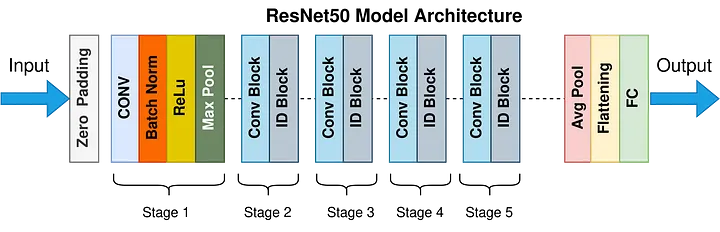

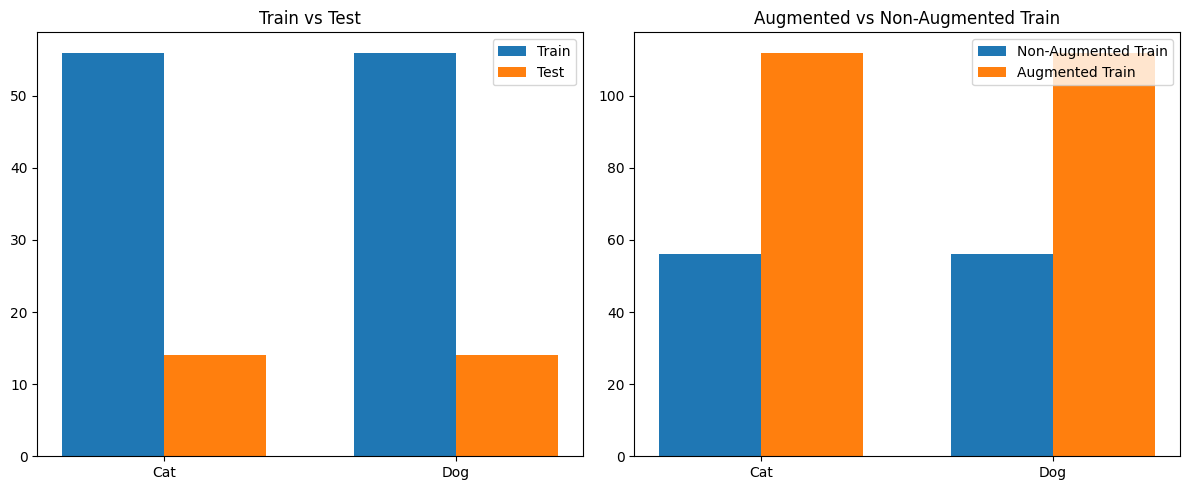

In [ ]:
# Cell 1: Image Counts Bar Graphs
import matplotlib.pyplot as plt
import numpy as np

# Update these counts if needed; here we're using your printed counts.
labels = ['Cat', 'Dog']
train_counts = [56, 56]           # Non-Augmented Train
test_counts  = [14, 14]           # Test
aug_train_counts = [112, 112]     # Augmented Train

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
index = np.arange(len(labels))
bar_width = 0.35

# Subplot: Train vs Test
axs[0].bar(index, train_counts, bar_width, label='Train')
axs[0].bar(index + bar_width, test_counts, bar_width, label='Test')
axs[0].set_title('Train vs Test')
axs[0].set_xticks(index + bar_width/2)
axs[0].set_xticklabels(labels)
axs[0].legend()

# Subplot: Non-Augmented Train vs Augmented Train
axs[1].bar(index, train_counts, bar_width, label='Non-Augmented Train')
axs[1].bar(index + bar_width, aug_train_counts, bar_width, label='Augmented Train')
axs[1].set_title('Augmented vs Non-Augmented Train')
axs[1].set_xticks(index + bar_width/2)
axs[1].set_xticklabels(labels)
axs[1].legend()

plt.tight_layout()
plt.show()


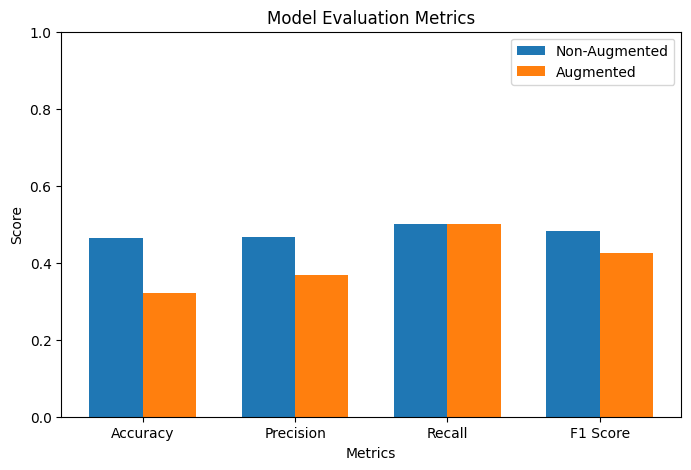

In [ ]:
# Cell 2: Evaluation Metrics Bar Graph
import matplotlib.pyplot as plt
import numpy as np

# Replace these with your computed metric values.
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
non_aug_scores = [accuracy_non_aug, precision_non_aug, recall_non_aug, f1_non_aug]
aug_scores     = [accuracy_aug, precision_aug, recall_aug, f1_aug]

index = np.arange(len(metrics))
bar_width = 0.35

plt.figure(figsize=(8,5))
plt.bar(index, non_aug_scores, bar_width, label='Non-Augmented')
plt.bar(index + bar_width, aug_scores, bar_width, label='Augmented')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.xticks(index + bar_width/2, metrics)
plt.ylim(0, 1)
plt.legend()
plt.show()


---

## 1. Image Counts Bar Graphs

### Graph 1: Train vs. Test Distribution

- **Purpose:**  
  To compare the number of images in the training set versus the test set for each class (Cat and Dog).

- **What It Shows:**  
  This graph helps verify that both the training and testing datasets are balanced. For instance, if you see 56 images for cats and 56 for dogs in training, and 14 images for each in testing, it confirms an even distribution across classes.

---

### Graph 2: Augmented vs. Non-Augmented Training Distribution

- **Purpose:**  
  To compare the number of images in the non-augmented training set with those in the augmented training set.

- **What It Shows:**  
  This graph demonstrates the effect of data augmentation. For example, if the non-augmented set has 56 images per class and the augmented set shows 112 images per class, it indicates that the augmentation process has successfully doubled the number of training images.

---

## Graph 3: Evaluation Metrics Bar Graph

- **Purpose:**  
  To compare the performance of two models (one trained on non-augmented data and one on augmented data) across several evaluation metrics.
- **What It Shows:**  
  This graph allows for a direct comparison of model performance. By visualizing the differences in accuracy, precision, recall, and F1 score, you can assess whether data augmentation has improved or affected the model's ability to correctly classify images.

---